## Analisi dei dati comunicati dalla Protezione civile relativi all'epidemia COVID-19 in Italia

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
#print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# we are using the inline backend
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

#!conda install -c conda-forge folium=0.5.0 --yes
#import folium # map rendering library

from datetime import datetime

pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

print('Libraries imported.')

Libraries imported.


In [2]:
# The code was removed by Watson Studio for sharing.

## Dati 1 aprile

In [3]:
body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='Italia-01.4.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_Italia = pd.read_csv(body)

body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='regioni-01.4.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_regioni = pd.read_csv(body)

body = client_6816ff6b00594052973bfb2ff7e1d9ef.get_object(Bucket='covid19-donotdelete-pr-un4kydphx068hf',Key='province-01.4.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_province = pd.read_csv(body)

In [4]:
def data_change(data):
    cut1=data.find(' ')
    cut2=data.find('T')
    data_str=data[0:max(cut1,cut2)]
    return (datetime.strptime(data_str, '%Y-%m-%d').date())

In [5]:
df_regioni['data']=df_regioni['data'].apply(data_change)
df_province['data']=df_province['data'].apply(data_change)
df_Italia['data']=df_Italia['data'].apply(data_change)

In [6]:
df_regioni.tail()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
793,2020-04-01,ITA,9,Toscana,43.769231,11.255889,1120,297,1417,3015,4432,206,259,182,253,4867,36575,NaN,NaN
794,2020-04-01,ITA,4,P.A. Trento,46.068935,11.121231,345,76,421,1062,1483,94,124,214,173,1870,7675,NaN,NaN
795,2020-04-01,ITA,10,Umbria,43.106758,12.388247,173,45,218,646,864,13,17,194,37,1095,9080,NaN,NaN
796,2020-04-01,ITA,2,Valle d'Aosta,45.737503,7.320149,85,27,112,428,540,-12,3,32,59,631,1717,NaN,NaN
797,2020-04-01,ITA,5,Veneto,45.434905,12.338452,1718,350,2068,6156,8224,374,470,902,499,9625,112746,NaN,NaN


In [7]:
df_province.tail()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note_it,note_en
4859,2020-04-01,ITA,5,Veneto,26,Treviso,TV,45.667546,12.245074,1554,NaN,NaN
4860,2020-04-01,ITA,5,Veneto,27,Venezia,VE,45.434905,12.338452,1231,NaN,NaN
4861,2020-04-01,ITA,5,Veneto,23,Verona,VR,45.438390,10.993527,2287,NaN,NaN
4862,2020-04-01,ITA,5,Veneto,24,Vicenza,VI,45.547497,11.545971,1327,NaN,NaN
4863,2020-04-01,ITA,5,Veneto,999,In fase di definizione/aggiornamento,NaN,0.000000,0.000000,258,NaN,NaN


In [8]:
df_Italia

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
0,2020-02-24,ITA,101,26,127,94,221,0,221,1,7,229,4324,NaN,NaN
1,2020-02-25,ITA,114,35,150,162,311,90,93,1,10,322,8623,NaN,NaN
2,2020-02-26,ITA,128,36,164,221,385,74,78,3,12,400,9587,NaN,NaN
3,2020-02-27,ITA,248,56,304,284,588,203,250,45,17,650,12014,NaN,NaN
4,2020-02-28,ITA,345,64,409,412,821,233,238,46,21,888,15695,NaN,NaN
5,2020-02-29,ITA,401,105,506,543,1049,228,240,50,29,1128,18661,NaN,NaN
6,2020-03-01,ITA,639,140,779,798,1577,528,566,83,34,1694,21127,NaN,NaN
7,2020-03-02,ITA,742,166,908,927,1835,258,342,149,52,2036,23345,NaN,NaN
8,2020-03-03,ITA,1034,229,1263,1000,2263,428,466,160,79,2502,25856,NaN,NaN
9,2020-03-04,ITA,1346,295,1641,1065,2706,443,587,276,107,3089,29837,NaN,NaN


In [9]:
def funcpol(x, a, b, c, d, e, f, g, h):
    return a+b*x+c*pow(x, 2)+d*pow(x, 3)+e*pow(x, 4)+f*pow(x, 5)+g*pow(x, 6)+h*pow(x, 7)

def funcexp(x, a, b, c):
    return a * np.exp(b * x) + c

def funcsigmoid(x, alfa, beta, gamma):
    return (beta/(1+np.exp(-gamma*(x-alfa))))

In [10]:
# addestra i parametri di una curva di tipo "func" sulla colonna "analisi" di "regione"
# ritorna un dataframe con una colonna contenente i dati "analisi" di "regione" e una colonna contenente
# i punti di "func". L'addestramento è fatto sui primi "len_stima" punti
def trend(regione, analisi, func, xdata, len_stima):
    df=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]]
    ydata=np.transpose(df[analisi][:len_stima].array)
    popt, pcov = curve_fit(func, xdata[:len_stima], ydata)
    yhat=func(xdata, *popt).astype(int)
    df['stima']=yhat
    return(df)

In [11]:
# addestra i parametri di una curva di tipo "func" sulla colonna "analisi" di Italia.
# ritorna un dataframe con una colonna contenente i dati "analisi" di Italia e una colonna contenente
# i punti di "func". L'addestramento è fatto sui primi "len_stima" punti
def trenditalia(len_stima, xdata, func, analisi):
    df=df_Italia[[analisi]]
    ydata=np.transpose(df_Italia[analisi][:len_stima].array)
    popt, pcov = curve_fit(func, xdata[:len_stima], ydata)
    yhat=func(xdata, *popt).astype(int)
    df['stima']=yhat
    return(df)

In [12]:
# disegna il grafico con i dati "analisi" di "regione" e la curva "func"
def graf(df, regione, analisi, xdata):
    ax1 = df.plot(kind='line', figsize=(8, 4))
    ax1.set_xticks(np.arange(0, len(xdata), 1))
    ax1.set_title('Trend regione {} stima calcolata primi {} giorni'.format(regione, len_stima))
    ax1.set_ylabel(analisi)
    ax1.set_xlabel('giorni dal 24 febbraio')

In [13]:
# disegna il grafico con i dati "analisi" di Italia e la curva "func"
def grafItalia(df, analisi, xdata):
    ax1 = df.plot(kind='line', figsize=(8, 4))
    ax1.set_xticks(np.arange(0, len(xdata), 1))
    ax1.set_title('Trend {} Italia stima calcolata primi {} giorni'.format(analisi, len_stima))
    ax1.set_ylabel(analisi)
    ax1.set_xlabel('giorni dal 24 febbraio')

In [14]:
N_days = df_Italia.shape[0]
xdata=np.linspace(0, N_days-1, N_days)

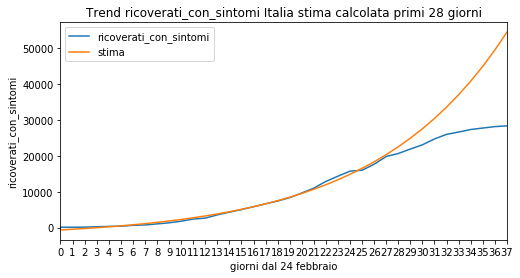

In [15]:
len_stima=28
analisi='ricoverati_con_sintomi'
df=trenditalia(len_stima, xdata, funcexp, analisi)

grafItalia(df, analisi, xdata)

In [16]:
# seleziona le N regioni con il maggior numero di ricoverati con sintomi
N=12
data=df_regioni['data'].iloc[len(df_regioni)-1]
top_N=df_regioni[df_regioni['data']==data].sort_values('ricoverati_con_sintomi', ascending=False).head(N)['denominazione_regione']

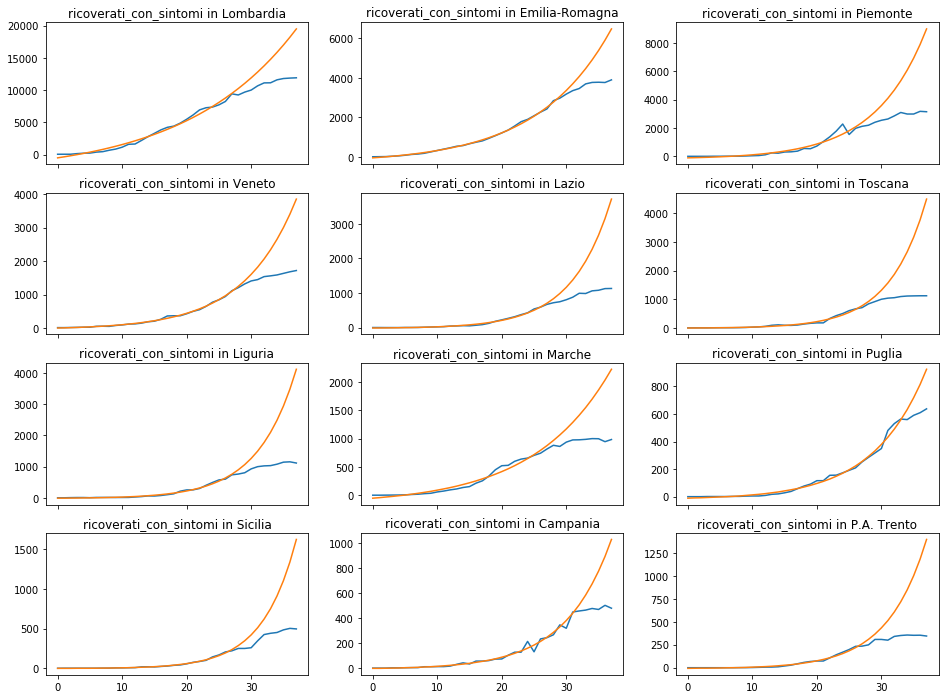

In [17]:
cols=min(len(top_N), 3)
rows=len(top_N)//3+1

if len(top_N)/3>len(top_N)//3:
    rows=len(top_N)//3+1
else:
    rows=len(top_N)//3

fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex='col')

indice=0
for row in range(rows):
    for col in range (cols):
        if indice<len(top_N):
            regione=top_N.iloc[indice]
            df=trend(regione, analisi, funcexp, xdata, len_stima)
            #popt, yhat, df=trend(regioni[indice], len_stima, N_days, funcexp)        
            axes[row,col].plot(xdata, df)
            axes[row,col].set_title('{} in {}'.format(analisi, regione))
            indice=indice+1

Text(0.5, 1.0, 'Frazione dei nuovi positivi sul numero di tamponi effettuati in Lazio')

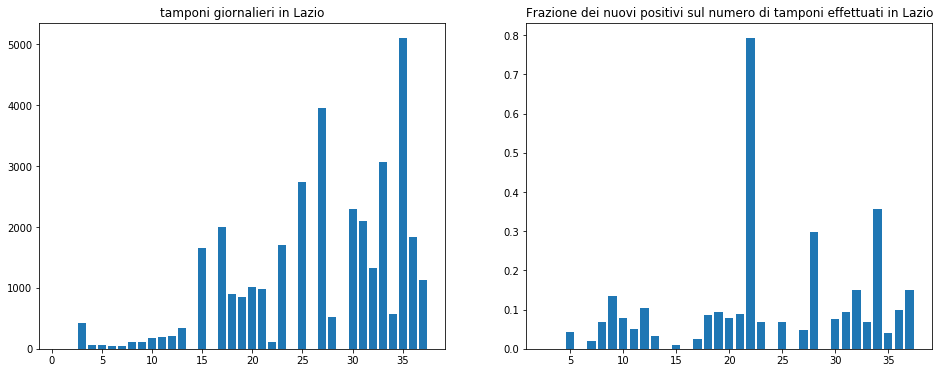

In [18]:
regione='Lazio'
analisi='tamponi'
df['tamponi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df['nuovi_positivi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[['nuovi_positivi']]
df['fraz']=df['nuovi_positivi']/df['tamponi']
axes[0].bar(xdata, df['tamponi'])
axes[0].set_title('{} giornalieri in {}'.format(analisi, regione))
axes[1].bar(xdata, df['fraz'])
axes[1].set_title('Frazione dei nuovi positivi sul numero di {} effettuati in {}'.format(analisi, regione))

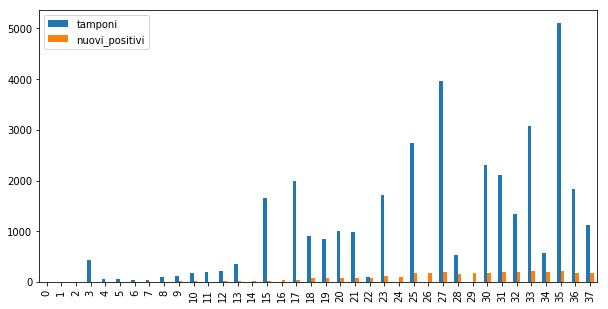

In [19]:
regione='Lazio'
analisi='tamponi'
df['tamponi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[[analisi]].diff()
df['nuovi_positivi']=df_regioni[df_regioni['denominazione_regione']==regione].reset_index()[['nuovi_positivi']]
ax = df[['tamponi', 'nuovi_positivi']].plot(kind='bar', figsize=(10, 5))

In [20]:
analisi='ricoverati_con_sintomi'

In [21]:
ydata=np.transpose(df_Italia[analisi].array)

In [22]:
# addestro una sigmoide con i primi "len_stima" dati della colonna analisi di una regione o dell'Italia
# e estendo la sigmoide fino a "len_sim" punti
len_stima=N_days
len_sim=50
popt, pcov = curve_fit(funcsigmoid, xdata[:len_stima], ydata[:len_stima], p0=[1, 0, 1])
yhat=funcsigmoid(np.linspace(0,len_sim-1,len_sim), *popt)

In [23]:
a = np.empty((len_sim-ydata.shape[0]))
a[:]=np.NaN
ydatanan=np.append(ydata,a)
d={'simulazione': yhat, 'dati reali': ydatanan}

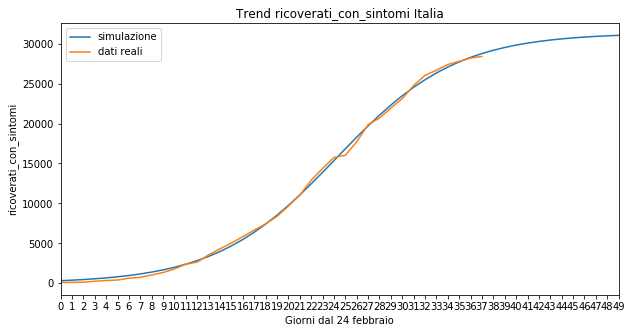

In [24]:
df = pd.DataFrame(data=d)
ax1 = df.plot(kind='line', figsize=(10, 5))
#ax1 = df[['dati reali']].plot(kind='scatter', figsize=(14, 5))
ax1.set_title('Trend {} Italia'.format(analisi))
ax1.set_ylabel(analisi)
ax1.set_xlabel('Giorni dal 24 febbraio')
x_ticks=ax1.set_xticks(np.arange(0, len_sim, 1))

In [25]:
regioni=['Lombardia', 'Veneto', 'Emilia-Romagna', 'Lazio']

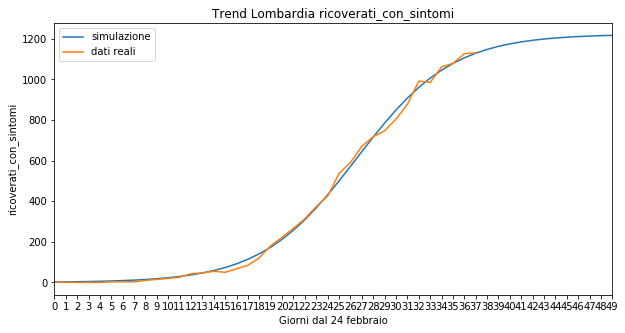

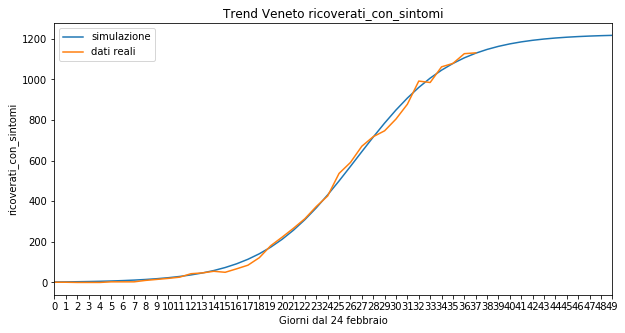

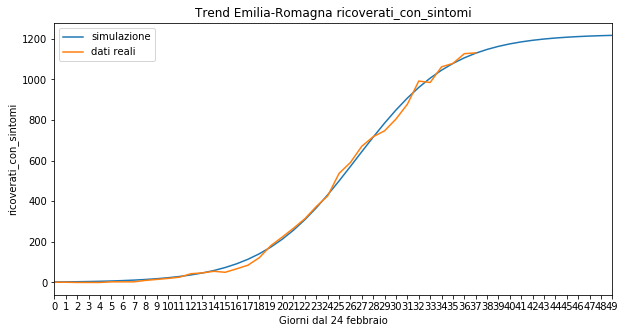

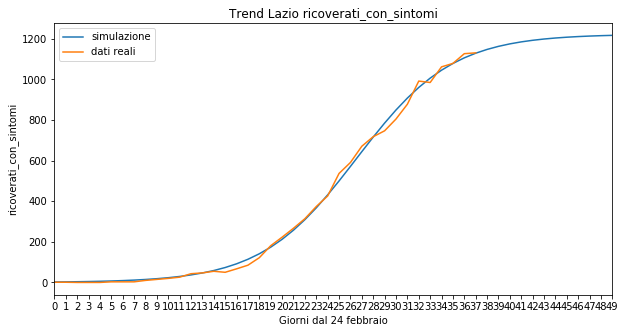

In [26]:
analisi='ricoverati_con_sintomi'
ydata=np.transpose(df_regioni[df_regioni['denominazione_regione']==regione][analisi].array)
len_stima=N_days
len_sim=50

for regione in regioni:
    popt, pcov = curve_fit(funcsigmoid, xdata[:len_stima], ydata[:len_stima], p0=[1, 0, 1])
    yhat=funcsigmoid(np.linspace(0,len_sim-1,len_sim), *popt)
    a = np.empty((len_sim-ydata.shape[0]))
    a[:]=np.NaN
    ydatanan=np.append(ydata,a)
    d={'simulazione': yhat, 'dati reali': ydatanan}
    df = pd.DataFrame(data=d)
    ax1 = df.plot(kind='line', figsize=(10, 5))
    ax1.set_title('Trend {} {}'.format(regione, analisi))
    ax1.set_ylabel(analisi)
    ax1.set_xlabel('Giorni dal 24 febbraio')
    x_ticks=ax1.set_xticks(np.arange(0, len_sim, 1))

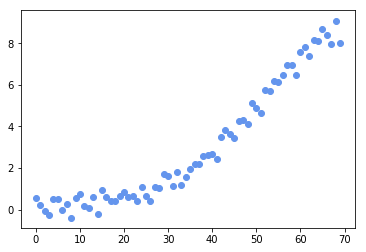

In [105]:
top=70
mu, sigma = 0, 0.3
s = np.random.normal(mu, sigma, 100)
X=np.linspace(0,99,100)
ydata=funcsigmoid(X[:top], 50, 10, 0.1)+s[:top]
plt.scatter(X[:top], ydata[:top], color='cornflowerblue')

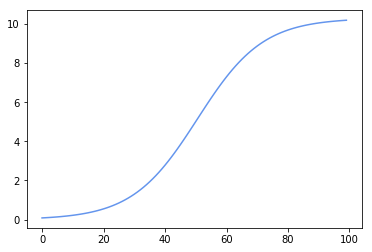

In [106]:
popt, pcov = curve_fit(funcsigmoid, X[:top], ydata[0:top])
yhat=funcsigmoid(X, *popt)
plt.plot(X, yhat, color='cornflowerblue')